In [22]:
import os
import librosa
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import Audio, display


In [60]:
def load_audio_features(file_path, n_mfcc=13):
    """
    Load an audio file and extract MFCC features.
    """
    y, sr = librosa.load(file_path, sr=None)
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Compute the mean of the MFCCs over time
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

def get_all_audio_features(directory, n_mfcc=13):
    """
    Load all .adg.ogg files in the directory and extract their MFCC features.
    """
    audio_features = {}
    for filename in os.listdir(directory):
        if filename.endswith('.ogg'):
            file_path = os.path.join(directory, filename)
            print(f"Processing {filename}... ({list(os.listdir(directory)).index(filename) + 1}/{len(os.listdir(directory))})")
            features = load_audio_features(file_path, n_mfcc)
            audio_features[filename] = features
    return audio_features

def rank_similar_files(input_filename, audio_features):
    """
    Rank files based on similarity to the input file.
    """
    input_features = audio_features[input_filename]
    other_files = {k: v for k, v in audio_features.items() if k != input_filename}

    # Compute cosine distances
    distances = {}
    for filename, features in other_files.items():
        # Compute cosine distance
        distance = cdist([input_features], [features], metric='cosine')[0][0]
        distances[filename] = distance

    # Sort files based on distance (lower distance = more similar)
    ranked_files = sorted(distances.items(), key=lambda x: x[1])
    return ranked_files

In [66]:
# Set your musicML directory path
musicml_directory = './inputs'  # Replace with your actual directory path

# Specify the input file you want to compare
input_filename = 'user_input.adg.ogg'  # Replace with your actual input file
input_file_path = os.path.join(musicml_directory, input_filename)

In [62]:
# get embeddings of all sounds in the musicML directory
# Ensure the input file exists in the directory

if not os.path.isfile(input_file_path):
    print(f"Input file {input_filename} not found in {musicml_directory}")
else:
    # Load features for all audio files
    audio_features = get_all_audio_features(musicml_directory)

Processing Canvas Kit Melodic 03 94 bpm.alc.ogg... (1/678)
Processing Bending Boom.adg.ogg... (2/678)
Processing Move Up Kit groove 03_110 bpm.alc.ogg... (3/678)
Processing Fluff Face Bass.adg.ogg... (4/678)
Processing Tempo Wah Clav Chords D Minor 94 bpm.alc.ogg... (5/678)
Processing Muddy Whirl Piano E Minor 01 85 bpm.alc.ogg... (6/678)
Processing Constant Pad G Minor 92 bpm.alc.ogg... (7/678)
Processing Analog Flute Lead.adg.ogg... (8/678)
Processing Little Amp Electric Piano.adg.ogg... (9/678)
Processing Beat That D Minor 98bpm.alc.ogg... (10/678)
Processing Kingsway Kit Melodic 02 100 bpm.alc.ogg... (11/678)
Processing 212 Kit Melodic 01 90 bpm.alc.ogg... (12/678)
Processing Little Amp Electric Piano Chords Bb minor 77bpm.alc.ogg... (13/678)
Processing Bi-Phase Sector.adg.ogg... (14/678)
Processing A Trying Sine D Minor 02 88 bpm.alc.ogg... (15/678)
Processing Dropped A Bass.adg.ogg... (16/678)
Processing Jiggy Groove 1 100 Bpm.alc.ogg... (17/678)
Processing Dirty Funk Lead.adg.og

In [64]:
import sounddevice as sd
import soundfile as sf

def record_audio(duration=2, sample_rate=44100):
    """
    Record audio from microphone and save as OGG file.
    
    Args:
        duration (int): Recording duration in seconds
        sample_rate (int): Sample rate in Hz
    """
    print("Recording...")
    # Record audio from microphone
    recording = sd.rec(int(duration * sample_rate), 
                      samplerate=sample_rate,
                      channels=1)
    sd.wait()  # Wait until recording is finished
    print("Recording finished")
    
    # Save as OGG file
    output_file = "user_input.adg.ogg" 
    sf.write(output_file, recording, sample_rate, format='OGG')
    print(f"Saved recording to {output_file}")
    
    return output_file

# Record 2 seconds of audio
recorded_file = record_audio()


Recording...
Recording finished
Saved recording to user_input.adg.ogg


In [65]:
# embed the new recorded file into the musicML directory
recorded_file_features = get_all_audio_features(recorded_file)
# append the new recorded file features to the audio_features dictionary
audio_features[input_filename] = recorded_file_features[input_filename]

NotADirectoryError: [Errno 20] Not a directory: 'user_input.adg.ogg'

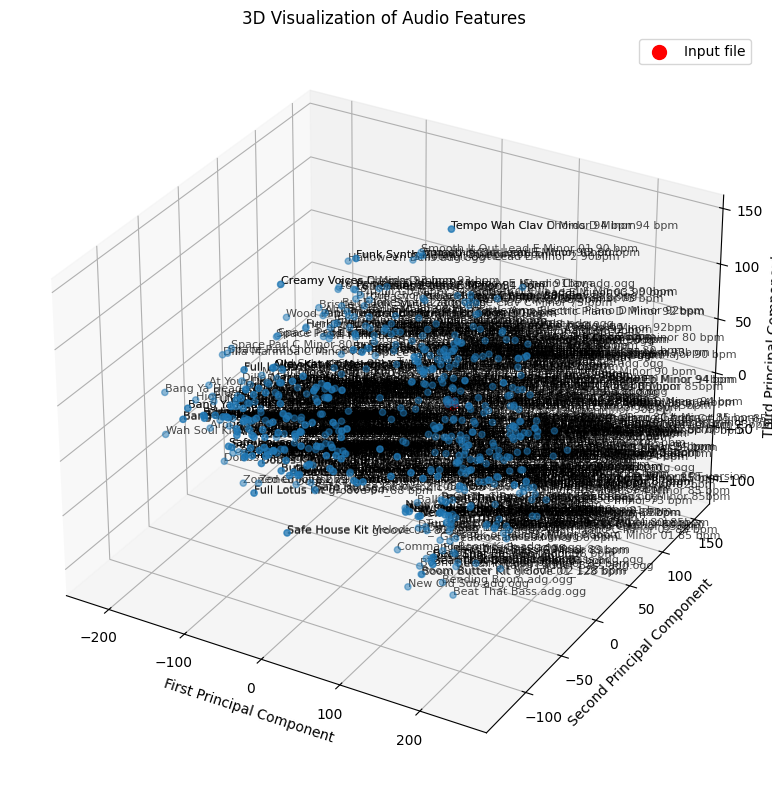

Explained variance ratio: [0.66330594 0.17101142 0.09668355]


In [56]:
# Visualize the audio feature vectors using PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert features dictionary to matrix form
feature_matrix = np.array(list(audio_features.values()))
filenames = list(audio_features.keys())

# Apply PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
features_3d = pca.fit_transform(feature_matrix)

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], alpha=0.5)

# Add labels for each point
for i, filename in enumerate(filenames):
    # Remove .adg.ogg extension for display
    display_name = filename.replace('.adg.ogg', '')
    display_name = filename.replace('.alc.ogg', '')
    ax.text(features_3d[i, 0], features_3d[i, 1], features_3d[i, 2],
            display_name, fontsize=8, alpha=0.7)

# Highlight the input file
input_idx = filenames.index(input_filename)
ax.scatter(features_3d[input_idx, 0], features_3d[input_idx, 1], features_3d[input_idx, 2],
          c='red', s=100, label='Input file')

ax.set_title('3D Visualization of Audio Features')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
plt.legend()
plt.tight_layout()
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


In [57]:
# Check if the input file's features were loaded
if input_filename not in audio_features:
    print(f"Could not load features for {input_filename}")
else:
    # Rank similar files
    ranked_files = rank_similar_files(input_filename, audio_features)

    # Display the results
    print(f"\nFiles similar to {input_filename}:")
    for rank, (filename, distance) in enumerate(ranked_files, start=1):
        similarity_score = 1 - distance  # Higher score means more similar
        print(f"{rank}. {filename} (Similarity Score: {similarity_score:.4f})")


Files similar to user_input.adg.ogg:
1. SH Funk Lead F# Minor 02 85 bpm.alc.ogg (Similarity Score: 0.9976)
2. SH Funk Lead F# Minor 2 85bpm.alc.ogg (Similarity Score: 0.9976)
3. Honey Pulp Lead.adg.ogg (Similarity Score: 0.9974)
4. Evening Casual E Minor 87 bpm.alc.ogg (Similarity Score: 0.9959)
5. Evening Casual E Minor 87bpm.alc.ogg (Similarity Score: 0.9958)
6. Evening Casual 6 Bb Minor 89bpm.alc.ogg (Similarity Score: 0.9957)
7. Evening Casual Bb Minor 06 89 bpm.alc.ogg (Similarity Score: 0.9953)
8. SH Funk Lead F# Minor 01 85 bpm.alc.ogg (Similarity Score: 0.9950)
9. SH Funk Lead F# Minor 85bpm.alc.ogg (Similarity Score: 0.9949)
10. Grind Bass.adg.ogg (Similarity Score: 0.9944)
11. Evening Casual 5 Bb Minor 89bpm.alc.ogg (Similarity Score: 0.9938)
12. Evening Casual Bb Minor 05 89 bpm.alc.ogg (Similarity Score: 0.9936)
13. Grind Bass D Minor 94 bpm.alc.ogg (Similarity Score: 0.9935)
14. Obee 12 Voice Brass.adg.ogg (Similarity Score: 0.9929)
15. Obee 12 Voice Brass C# Minor 85 bpm

In [63]:
# Function to play audio files
def play_audio(file_path):
    y, sr = librosa.load(file_path)
    display(Audio(y, rate=sr))

# Play the input file first
print("\nPlaying input file:")
input_file_path = os.path.join(musicml_directory, input_filename)
print(f"Playing {input_filename}")
play_audio(input_file_path)

# Play the top 10 most similar files
print("\nPlaying top 10 most similar files:")
for rank, (filename, distance) in enumerate(ranked_files[:10], start=1):
    file_path = os.path.join(musicml_directory, filename)
    print(f"\n{rank}. Playing {filename}")
    play_audio(file_path)



Playing input file:
Playing user_input.adg.ogg



Playing top 10 most similar files:

1. Playing SH Funk Lead F# Minor 02 85 bpm.alc.ogg



2. Playing SH Funk Lead F# Minor 2 85bpm.alc.ogg



3. Playing Honey Pulp Lead.adg.ogg



4. Playing Evening Casual E Minor 87 bpm.alc.ogg



5. Playing Evening Casual E Minor 87bpm.alc.ogg



6. Playing Evening Casual 6 Bb Minor 89bpm.alc.ogg



7. Playing Evening Casual Bb Minor 06 89 bpm.alc.ogg



8. Playing SH Funk Lead F# Minor 01 85 bpm.alc.ogg



9. Playing SH Funk Lead F# Minor 85bpm.alc.ogg



10. Playing Grind Bass.adg.ogg
